# Tennis Dataset Analysis - ML4QS Chapter 2
## Comprehensive Analysis of Multi-Video Tennis Temporal Dataset

This notebook analyzes the comprehensive temporal dataset created from processing 17 tennis videos.
The analysis demonstrates ML4QS Chapter 2 concepts applied to real tennis data:

- **Temporal Data Analysis**: Time-series analysis of player and ball movements
- **Data Quality Assessment**: Missing data patterns and detection rates
- **Feature Engineering**: Derived metrics from raw position data
- **Multi-object Tracking**: Coordinated analysis of players and ball
- **Court-calibrated Measurements**: Real-world distances and speeds
- **Statistical Analysis**: Performance metrics and movement patterns

## 1. Data Loading and Initial Exploration

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📊 TENNIS DATASET ANALYSIS - ML4QS Chapter 2")
print("=" * 60)
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📊 TENNIS DATASET ANALYSIS - ML4QS Chapter 2
Analysis started: 2025-06-22 01:51:12


In [26]:
# Load the comprehensive temporal dataset
dataset_file = 'tennis_comprehensive_temporal_dataset_20250622_012949.csv'

try:
    print(f"📂 Loading dataset: {dataset_file}")
    df = pd.read_csv(dataset_file, index_col=0, parse_dates=True)
    
    print(f"✅ Dataset loaded successfully!")
    print(f"   📏 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   📅 Time range: {df.index.min()} to {df.index.max()}")
    print(f"   ⏱️ Duration: {df['time_seconds'].max():.1f} seconds ({df['time_seconds'].max()/60:.1f} minutes)")
    
except FileNotFoundError:
    print(f"❌ Dataset file not found: {dataset_file}")
    print("Please ensure the file exists in the current directory")
    raise
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    raise

📂 Loading dataset: tennis_comprehensive_temporal_dataset_20250622_012949.csv
✅ Dataset loaded successfully!
   📏 Shape: 9,882 rows × 72 columns
   📅 Time range: 2024-01-01 00:00:00 to 2024-01-01 00:05:29.333730
   ⏱️ Duration: 329.4 seconds (5.5 minutes)


In [27]:
# Dataset overview and structure
print("📋 DATASET STRUCTURE OVERVIEW")
print("=" * 50)

# Categorize columns by type
column_categories = {
    'Temporal': [col for col in df.columns if any(x in col.lower() for x in ['frame', 'time', 'seconds'])],
    'Ball': [col for col in df.columns if col.startswith('ball_')],
    'Player 1': [col for col in df.columns if col.startswith('player_1_')],
    'Player 2': [col for col in df.columns if col.startswith('player_2_')],
    'Court': [col for col in df.columns if col.startswith('court_')],
    'Detection/State': [col for col in df.columns if any(x in col for x in ['detected', 'rate', 'transition'])],
}

print("Column Categories:")
for category, columns in column_categories.items():
    print(f"  {category}: {len(columns)} columns")
    if len(columns) <= 5:
        print(f"    {', '.join(columns)}")
    else:
        print(f"    {', '.join(columns[:3])}... (+{len(columns)-3} more)")

print(f"\n📊 Data Types:")
data_types = df.dtypes.value_counts()
for dtype, count in data_types.items():
    print(f"  {dtype}: {count} columns")

📋 DATASET STRUCTURE OVERVIEW
Column Categories:
  Temporal: 2 columns
    global_frame_number, time_seconds
  Ball: 17 columns
    ball_center_x, ball_center_y, ball_x1... (+14 more)
  Player 1: 20 columns
    player_1_center_x, player_1_center_y, player_1_x1... (+17 more)
  Player 2: 20 columns
    player_2_center_x, player_2_center_y, player_2_x1... (+17 more)
  Court: 10 columns
    court_single_line_width_meters, court_double_line_width_meters, court_half_court_height_meters... (+7 more)
  Detection/State: 9 columns
    ball_detected, player_1_detected, player_2_detected... (+6 more)

📊 Data Types:
  float64: 60 columns
  bool: 6 columns
  object: 5 columns
  int64: 1 columns


In [28]:
# Basic statistical summary
print("📈 BASIC DATASET STATISTICS")
print("=" * 50)

# Detection rates
if 'ball_detected' in df.columns:
    ball_detection_rate = df['ball_detected'].mean()
    print(f"⚽ Ball Detection Rate: {ball_detection_rate:.1%} ({df['ball_detected'].sum():,} / {len(df):,} frames)")

if 'player_1_detected' in df.columns:
    player1_detection_rate = df['player_1_detected'].mean()
    print(f"👤 Player 1 Detection Rate: {player1_detection_rate:.1%} ({df['player_1_detected'].sum():,} / {len(df):,} frames)")

if 'player_2_detected' in df.columns:
    player2_detection_rate = df['player_2_detected'].mean()
    print(f"👤 Player 2 Detection Rate: {player2_detection_rate:.1%} ({df['player_2_detected'].sum():,} / {len(df):,} frames)")

if 'both_players_detected' in df.columns:
    both_players_rate = df['both_players_detected'].mean()
    print(f"👥 Both Players Detected: {both_players_rate:.1%} ({df['both_players_detected'].sum():,} frames)")

if 'all_objects_detected' in df.columns:
    all_objects_rate = df['all_objects_detected'].mean()
    print(f"🎯 All Objects Detected: {all_objects_rate:.1%} ({df['all_objects_detected'].sum():,} frames)")

# Court measurements
print(f"\n🏟️ Court Information:")
court_cols = [col for col in df.columns if col.startswith('court_') and 'meters' in col]
if court_cols:
    for col in court_cols[:5]:  # Show first 5 court measurements
        value = df[col].iloc[0] if not df[col].isna().all() else 'N/A'
        measurement_name = col.replace('court_', '').replace('_meters', '').replace('_', ' ').title()
        print(f"  {measurement_name}: {value}")

# Video information
if 'ball_video_source' in df.columns:
    unique_videos = df['ball_video_source'].dropna().nunique()
    print(f"\n📹 Video Information:")
    print(f"  Unique videos in dataset: {unique_videos}")
elif 'player_1_video_source' in df.columns:
    unique_videos = df['player_1_video_source'].dropna().nunique()
    print(f"\n📹 Video Information:")
    print(f"  Unique videos in dataset: {unique_videos}")

📈 BASIC DATASET STATISTICS
⚽ Ball Detection Rate: 44.3% (4,382 / 9,882 frames)
👤 Player 1 Detection Rate: 100.0% (9,882 / 9,882 frames)
👤 Player 2 Detection Rate: 100.0% (9,882 / 9,882 frames)
👥 Both Players Detected: 100.0% (9,882 frames)
🎯 All Objects Detected: 44.3% (4,382 frames)

🏟️ Court Information:
  Single Line Width: 8.23
  Double Line Width: 10.97
  Half Height: 11.88
  Service Line Width: 6.4
  Double Alley Difference: 1.37

📹 Video Information:
  Unique videos in dataset: 17


## 2. Data Quality Assessment

In [29]:
# Missing data analysis
print("🔍 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Calculate missing data percentages
missing_data = df.isnull().sum()
missing_percentages = (missing_data / len(df)) * 100

# Focus on key tracking columns
key_tracking_cols = [col for col in df.columns if any(x in col for x in ['center_x', 'center_y', 'speed', 'distance'])]

print("Missing Data in Key Tracking Columns:")
for col in key_tracking_cols:
    if col in missing_percentages.index:
        missing_pct = missing_percentages[col]
        if missing_pct > 0:
            print(f"  {col}: {missing_pct:.1f}% missing ({missing_data[col]:,} / {len(df):,} frames)")

# Detection continuity analysis
print(f"\n📊 Detection Continuity Analysis:")

if 'ball_detected' in df.columns:
    # Calculate consecutive detection streaks for ball
    ball_streaks = df['ball_detected'].astype(int).diff().ne(0).cumsum()
    ball_streak_lengths = df.groupby(ball_streaks)['ball_detected'].sum()
    ball_detected_streaks = ball_streak_lengths[ball_streak_lengths > 0]
    
    if len(ball_detected_streaks) > 0:
        print(f"  Ball detection streaks: {len(ball_detected_streaks)} streaks")
        print(f"    Average streak length: {ball_detected_streaks.mean():.1f} frames")
        print(f"    Longest streak: {ball_detected_streaks.max()} frames ({ball_detected_streaks.max()/30:.1f}s)")
        print(f"    Shortest streak: {ball_detected_streaks.min()} frames")

# Frame rate consistency
if 'time_seconds' in df.columns:
    time_diffs = df['time_seconds'].diff().dropna()
    expected_frame_time = 1/30  # 30 fps
    actual_avg_frame_time = time_diffs.mean()
    
    print(f"\n⏱️ Temporal Consistency:")
    print(f"  Expected frame interval: {expected_frame_time:.4f}s (30 fps)")
    print(f"  Actual average interval: {actual_avg_frame_time:.4f}s")
    print(f"  Timing consistency: {'Good' if abs(actual_avg_frame_time - expected_frame_time) < 0.001 else 'Variable'}")

🔍 DATA QUALITY ASSESSMENT
Missing Data in Key Tracking Columns:
  ball_center_x: 55.7% missing (5,500 / 9,882 frames)
  ball_center_y: 55.7% missing (5,500 / 9,882 frames)

📊 Detection Continuity Analysis:
  Ball detection streaks: 1777 streaks
    Average streak length: 2.5 frames
    Longest streak: 7 frames (0.2s)
    Shortest streak: 1 frames

⏱️ Temporal Consistency:
  Expected frame interval: 0.0333s (30 fps)
  Actual average interval: 0.0333s
  Timing consistency: Good


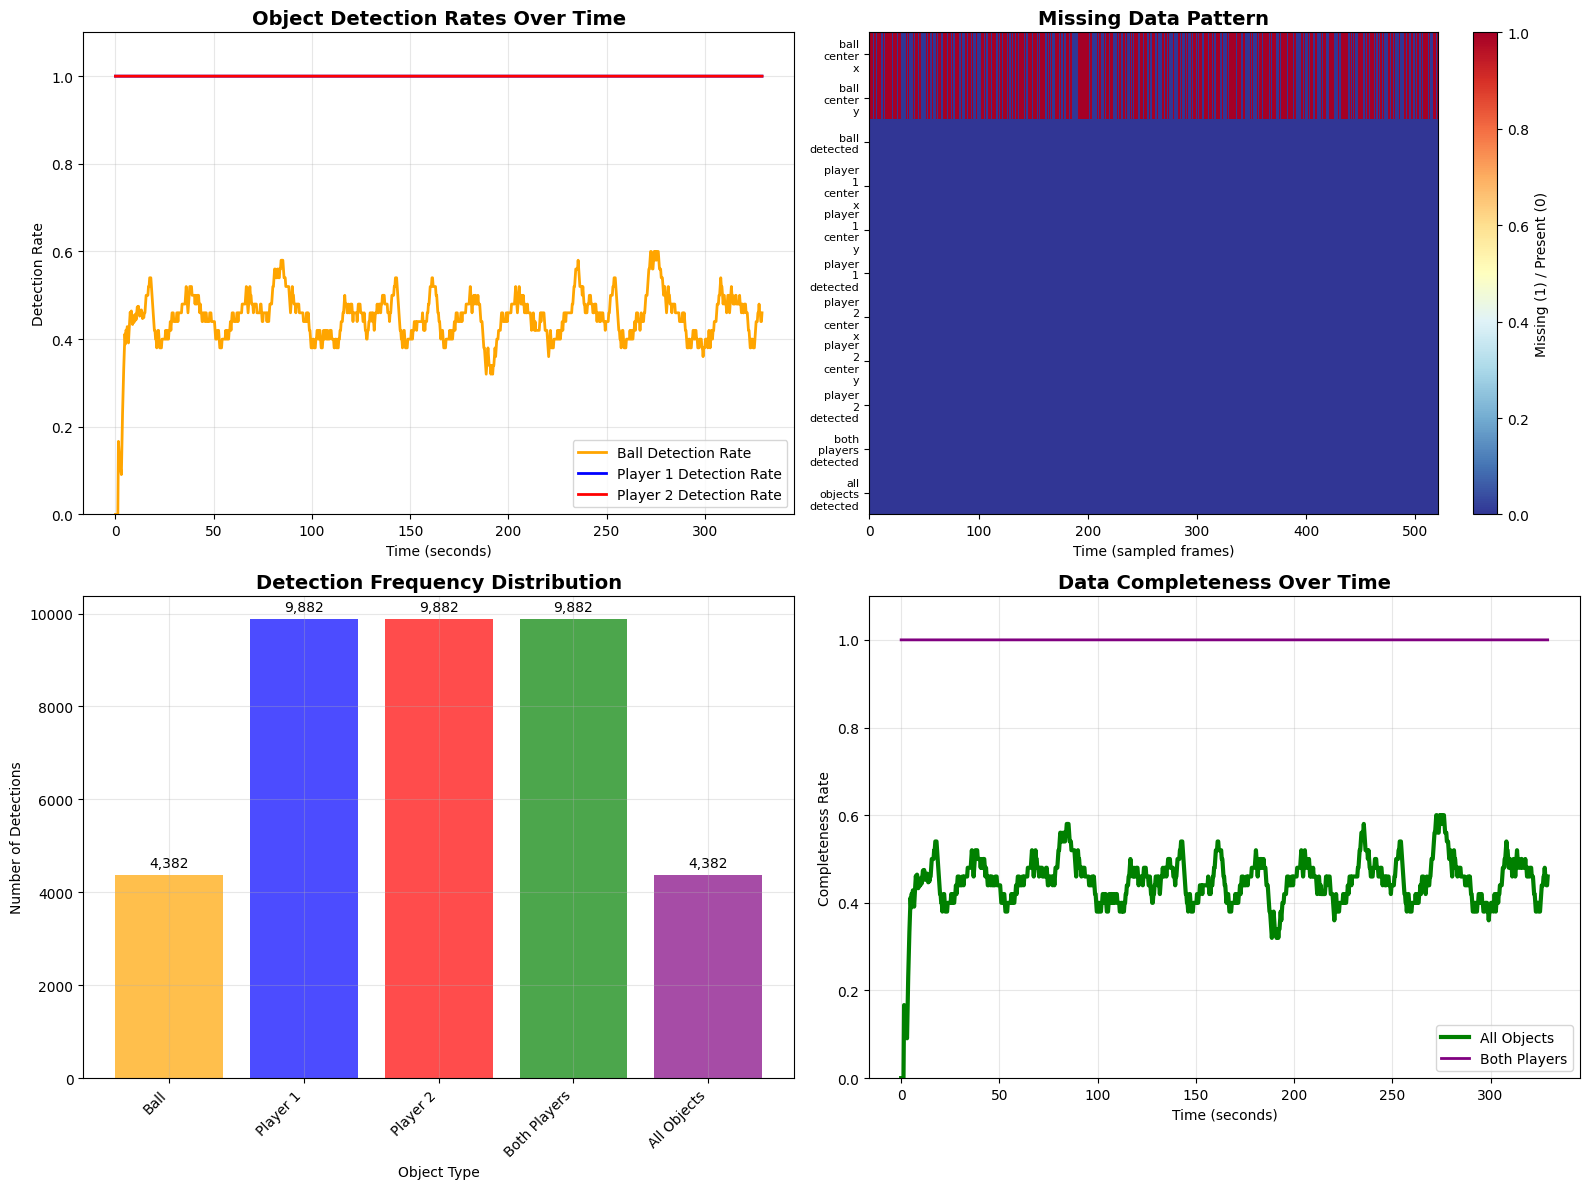

✅ Data quality visualizations created
   Sampled every 9 frames for visualization clarity


In [30]:
# Create data quality visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Detection rates over time
ax1.set_title('Object Detection Rates Over Time', fontsize=14, fontweight='bold')

# Sample data for visualization (every 100th frame to avoid overcrowding)
sample_interval = max(1, len(df) // 1000)
sample_df = df.iloc[::sample_interval].copy()

if 'ball_detected' in sample_df.columns:
    # Rolling average for smoother visualization
    window_size = min(50, len(sample_df) // 10)
    ball_rolling = sample_df['ball_detected'].rolling(window=window_size, min_periods=1).mean()
    ax1.plot(sample_df['time_seconds'], ball_rolling, label='Ball Detection Rate', linewidth=2, color='orange')

if 'player_1_detected' in sample_df.columns:
    player1_rolling = sample_df['player_1_detected'].rolling(window=window_size, min_periods=1).mean()
    ax1.plot(sample_df['time_seconds'], player1_rolling, label='Player 1 Detection Rate', linewidth=2, color='blue')

if 'player_2_detected' in sample_df.columns:
    player2_rolling = sample_df['player_2_detected'].rolling(window=window_size, min_periods=1).mean()
    ax1.plot(sample_df['time_seconds'], player2_rolling, label='Player 2 Detection Rate', linewidth=2, color='red')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Detection Rate')
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Missing data heatmap
ax2.set_title('Missing Data Pattern', fontsize=14, fontweight='bold')

# Select key columns for missing data visualization
key_cols = [col for col in df.columns if any(x in col for x in ['center_x', 'center_y', 'detected'])]
if len(key_cols) > 0:
    # Sample data for heatmap
    heatmap_sample = df[key_cols].iloc[::max(1, len(df)//500)]
    
    # Create binary missing data matrix
    missing_matrix = heatmap_sample.isnull().astype(int)
    
    im = ax2.imshow(missing_matrix.T, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
    ax2.set_yticks(range(len(key_cols)))
    ax2.set_yticklabels([col.replace('_', '\n') for col in key_cols], fontsize=8)
    ax2.set_xlabel('Time (sampled frames)')
    plt.colorbar(im, ax=ax2, label='Missing (1) / Present (0)')
else:
    ax2.text(0.5, 0.5, 'No key columns found for missing data analysis', 
             transform=ax2.transAxes, ha='center', va='center')

# 3. Detection frequency distribution
ax3.set_title('Detection Frequency Distribution', fontsize=14, fontweight='bold')

detection_cols = [col for col in df.columns if col.endswith('_detected')]
if detection_cols:
    detection_counts = []
    labels = []
    
    for col in detection_cols:
        count = df[col].sum()
        detection_counts.append(count)
        # Clean up label names
        label = col.replace('_detected', '').replace('_', ' ').title()
        labels.append(label)
    
    bars = ax3.bar(labels, detection_counts, alpha=0.7, color=['orange', 'blue', 'red', 'green', 'purple'][:len(labels)])
    ax3.set_ylabel('Number of Detections')
    ax3.set_xlabel('Object Type')
    
    # Add value labels on bars
    for bar, count in zip(bars, detection_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(detection_counts)*0.01,
                f'{count:,}', ha='center', va='bottom', fontsize=10)
    
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax3.text(0.5, 0.5, 'No detection columns found', 
             transform=ax3.transAxes, ha='center', va='center')

ax3.grid(True, alpha=0.3)

# 4. Data completeness over time
ax4.set_title('Data Completeness Over Time', fontsize=14, fontweight='bold')

if 'all_objects_detected' in sample_df.columns:
    completeness_rolling = sample_df['all_objects_detected'].rolling(window=window_size, min_periods=1).mean()
    ax4.plot(sample_df['time_seconds'], completeness_rolling, label='All Objects', linewidth=3, color='green')

if 'both_players_detected' in sample_df.columns:
    both_players_rolling = sample_df['both_players_detected'].rolling(window=window_size, min_periods=1).mean()
    ax4.plot(sample_df['time_seconds'], both_players_rolling, label='Both Players', linewidth=2, color='purple')

ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Completeness Rate')
ax4.set_ylim(0, 1.1)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Data quality visualizations created")
print(f"   Sampled every {sample_interval} frames for visualization clarity")

## 3. Movement and Speed Analysis

In [31]:
# Movement and speed analysis
print("🏃 MOVEMENT AND SPEED ANALYSIS")
print("=" * 50)

# Analyze player speeds
speed_stats = {}

for player_id in [1, 2]:
    speed_col = f'player_{player_id}_speed_kmh'
    distance_col = f'player_{player_id}_distance_meters'
    
    if speed_col in df.columns:
        player_speeds = df[speed_col].dropna()
        player_distances = df[distance_col].dropna() if distance_col in df.columns else pd.Series()
        
        if len(player_speeds) > 0:
            # Filter out unrealistic speeds (> 50 km/h for tennis players)
            realistic_speeds = player_speeds[player_speeds <= 50]
            
            speed_stats[f'Player {player_id}'] = {
                'count': len(realistic_speeds),
                'mean_speed': realistic_speeds.mean(),
                'median_speed': realistic_speeds.median(),
                'max_speed': realistic_speeds.max(),
                'std_speed': realistic_speeds.std(),
                'total_distance': player_distances.sum() if len(player_distances) > 0 else 0
            }
            
            print(f"\n👤 Player {player_id} Movement Statistics:")
            print(f"   Total movement samples: {len(realistic_speeds):,}")
            print(f"   Average speed: {realistic_speeds.mean():.1f} km/h")
            print(f"   Median speed: {realistic_speeds.median():.1f} km/h")
            print(f"   Maximum speed: {realistic_speeds.max():.1f} km/h")
            print(f"   Speed variability (std): {realistic_speeds.std():.1f} km/h")
            if len(player_distances) > 0:
                print(f"   Total distance traveled: {player_distances.sum():.1f} meters")

# Ball speed analysis
if 'ball_speed_kmh' in df.columns:
    ball_speeds = df['ball_speed_kmh'].dropna()
    ball_distances = df['ball_distance_meters'].dropna() if 'ball_distance_meters' in df.columns else pd.Series()
    
    if len(ball_speeds) > 0:
        # Filter out unrealistic ball speeds (> 200 km/h is quite fast for tennis)
        realistic_ball_speeds = ball_speeds[ball_speeds <= 200]
        
        print(f"\n⚽ Ball Movement Statistics:")
        print(f"   Total movement samples: {len(realistic_ball_speeds):,}")
        print(f"   Average speed: {realistic_ball_speeds.mean():.1f} km/h")
        print(f"   Median speed: {realistic_ball_speeds.median():.1f} km/h")
        print(f"   Maximum speed: {realistic_ball_speeds.max():.1f} km/h")
        print(f"   Speed variability (std): {realistic_ball_speeds.std():.1f} km/h")
        if len(ball_distances) > 0:
            print(f"   Total distance traveled: {ball_distances.sum():.1f} meters")

# Movement patterns analysis
print(f"\n📊 Movement Patterns:")

# Analyze court region usage
for player_id in [1, 2]:
    region_col = f'player_{player_id}_court_region'
    if region_col in df.columns:
        region_counts = df[region_col].value_counts()
        if len(region_counts) > 0:
            print(f"\n   Player {player_id} court region usage:")
            for region, count in region_counts.head().items():
                percentage = (count / len(df)) * 100
                print(f"     {region.replace('_', ' ').title()}: {percentage:.1f}% ({count:,} frames)")

🏃 MOVEMENT AND SPEED ANALYSIS

👤 Player 1 Movement Statistics:
   Total movement samples: 9,829
   Average speed: 6.3 km/h
   Median speed: 5.7 km/h
   Maximum speed: 39.8 km/h
   Speed variability (std): 3.9 km/h
   Total distance traveled: 804.6 meters

👤 Player 2 Movement Statistics:
   Total movement samples: 9,833
   Average speed: 3.9 km/h
   Median speed: 2.9 km/h
   Maximum speed: 38.8 km/h
   Speed variability (std): 3.5 km/h
   Total distance traveled: 391.8 meters

⚽ Ball Movement Statistics:
   Total movement samples: 9,882
   Average speed: 4.1 km/h
   Median speed: 0.0 km/h
   Maximum speed: 44.5 km/h
   Speed variability (std): 9.2 km/h
   Total distance traveled: 378.2 meters

📊 Movement Patterns:

   Player 1 court region usage:
     Back Court Near: 100.0% (9,882 frames)

   Player 2 court region usage:
     Back Court Far: 51.5% (5,094 frames)
     Service Area Far: 48.5% (4,788 frames)


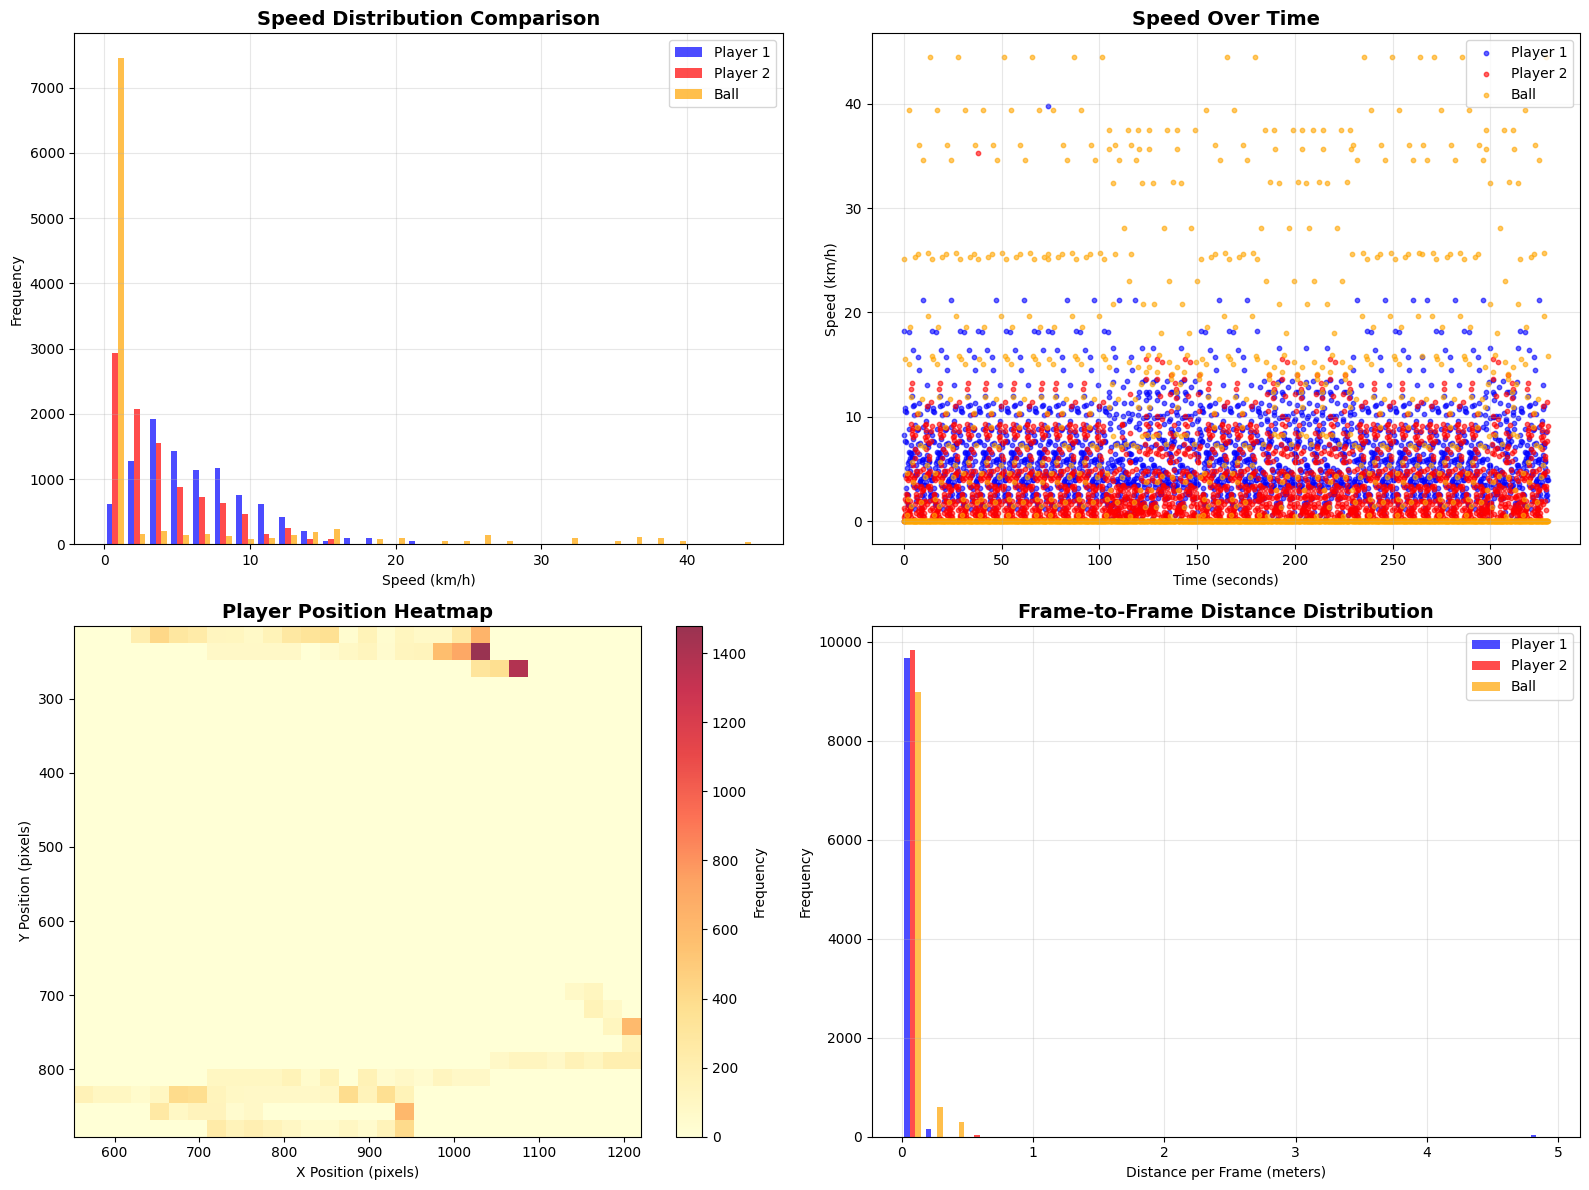

✅ Movement analysis visualizations created


In [32]:
# Create movement analysis visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Speed distribution comparison
ax1.set_title('Speed Distribution Comparison', fontsize=14, fontweight='bold')

# Plot speed distributions
colors = ['blue', 'red', 'orange']
labels = []
speed_data = []

for i, player_id in enumerate([1, 2]):
    speed_col = f'player_{player_id}_speed_kmh'
    if speed_col in df.columns:
        speeds = df[speed_col].dropna()
        realistic_speeds = speeds[speeds <= 50]  # Filter unrealistic speeds
        if len(realistic_speeds) > 0:
            speed_data.append(realistic_speeds)
            labels.append(f'Player {player_id}')

if 'ball_speed_kmh' in df.columns:
    ball_speeds = df['ball_speed_kmh'].dropna()
    realistic_ball_speeds = ball_speeds[ball_speeds <= 200]
    if len(realistic_ball_speeds) > 0:
        speed_data.append(realistic_ball_speeds)
        labels.append('Ball')

if speed_data:
    ax1.hist(speed_data, bins=30, alpha=0.7, label=labels, color=colors[:len(speed_data)])
    ax1.set_xlabel('Speed (km/h)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No speed data available', transform=ax1.transAxes, ha='center', va='center')

# 2. Speed over time
ax2.set_title('Speed Over Time', fontsize=14, fontweight='bold')

# Sample data for time series plot
sample_df = df.iloc[::max(1, len(df)//2000)].copy()

for player_id, color in zip([1, 2], ['blue', 'red']):
    speed_col = f'player_{player_id}_speed_kmh'
    if speed_col in sample_df.columns:
        speeds = sample_df[speed_col].dropna()
        realistic_speeds = speeds[speeds <= 50]
        
        if len(realistic_speeds) > 0:
            # Get corresponding time values
            time_values = sample_df.loc[realistic_speeds.index, 'time_seconds']
            ax2.scatter(time_values, realistic_speeds, alpha=0.6, s=10, 
                       color=color, label=f'Player {player_id}')

if 'ball_speed_kmh' in sample_df.columns:
    ball_speeds = sample_df['ball_speed_kmh'].dropna()
    realistic_ball_speeds = ball_speeds[ball_speeds <= 200]
    
    if len(realistic_ball_speeds) > 0:
        time_values = sample_df.loc[realistic_ball_speeds.index, 'time_seconds']
        ax2.scatter(time_values, realistic_ball_speeds, alpha=0.6, s=10, 
                   color='orange', label='Ball')

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Speed (km/h)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Court position heatmap
ax3.set_title('Player Position Heatmap', fontsize=14, fontweight='bold')

# Combine player positions for heatmap
all_x_positions = []
all_y_positions = []

for player_id in [1, 2]:
    x_col = f'player_{player_id}_center_x'
    y_col = f'player_{player_id}_center_y'
    
    if x_col in df.columns and y_col in df.columns:
        player_data = df[[x_col, y_col]].dropna()
        if len(player_data) > 0:
            all_x_positions.extend(player_data[x_col].tolist())
            all_y_positions.extend(player_data[y_col].tolist())

if all_x_positions and all_y_positions:
    # Create 2D histogram
    h = ax3.hist2d(all_x_positions, all_y_positions, bins=30, cmap='YlOrRd', alpha=0.8)
    plt.colorbar(h[3], ax=ax3, label='Frequency')
    ax3.set_xlabel('X Position (pixels)')
    ax3.set_ylabel('Y Position (pixels)')
    ax3.invert_yaxis()  # Invert Y to match video coordinate system
else:
    ax3.text(0.5, 0.5, 'No position data available', transform=ax3.transAxes, ha='center', va='center')

# 4. Movement distance distribution
ax4.set_title('Frame-to-Frame Distance Distribution', fontsize=14, fontweight='bold')

distance_data = []
distance_labels = []

for player_id in [1, 2]:
    distance_col = f'player_{player_id}_distance_meters'
    if distance_col in df.columns:
        distances = df[distance_col].dropna()
        # Filter out unrealistic distances (> 5 meters per frame at 30fps)
        realistic_distances = distances[distances <= 5]
        if len(realistic_distances) > 0:
            distance_data.append(realistic_distances)
            distance_labels.append(f'Player {player_id}')

if 'ball_distance_meters' in df.columns:
    ball_distances = df['ball_distance_meters'].dropna()
    realistic_ball_distances = ball_distances[ball_distances <= 10]  # Ball can move faster
    if len(realistic_ball_distances) > 0:
        distance_data.append(realistic_ball_distances)
        distance_labels.append('Ball')

if distance_data:
    ax4.hist(distance_data, bins=30, alpha=0.7, label=distance_labels, 
             color=colors[:len(distance_data)])
    ax4.set_xlabel('Distance per Frame (meters)')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No distance data available', transform=ax4.transAxes, ha='center', va='center')

plt.tight_layout()
plt.show()

print("✅ Movement analysis visualizations created")

## 4. Temporal Pattern Analysis

In [33]:
# Temporal pattern analysis
print("📅 TEMPORAL PATTERN ANALYSIS")
print("=" * 50)

# Analyze detection patterns over time
print("🔍 Detection Pattern Analysis:")

# Video transition analysis
if 'video_transition' in df.columns:
    transitions = df['video_transition'].sum()
    print(f"   Total video transitions: {transitions}")
    
    # Analyze data around transitions
    transition_indices = df[df['video_transition'] == True].index
    if len(transition_indices) > 0:
        print(f"   Average time between transitions: {df['time_seconds'].max() / transitions:.1f} seconds")

# Ball trajectory analysis
if 'ball_center_x' in df.columns and 'ball_center_y' in df.columns:
    ball_data = df[['ball_center_x', 'ball_center_y']].dropna()
    
    if len(ball_data) > 1:
        print(f"\n⚽ Ball Trajectory Analysis:")
        
        # Calculate trajectory characteristics
        x_range = ball_data['ball_center_x'].max() - ball_data['ball_center_x'].min()
        y_range = ball_data['ball_center_y'].max() - ball_data['ball_center_y'].min()
        
        print(f"   Ball movement range: X = {x_range:.1f} pixels, Y = {y_range:.1f} pixels")
        print(f"   Ball center position: ({ball_data['ball_center_x'].mean():.1f}, {ball_data['ball_center_y'].mean():.1f}) pixels")
        
        # Analyze ball height changes (Y position)
        ball_y_changes = ball_data['ball_center_y'].diff().dropna()
        upward_movement = (ball_y_changes < 0).sum()  # Y decreases = upward in image
        downward_movement = (ball_y_changes > 0).sum()  # Y increases = downward in image
        
        print(f"   Ball movement direction: {upward_movement} upward frames, {downward_movement} downward frames")

# Player interaction analysis
print(f"\n👥 Player Interaction Analysis:")

if all(f'player_{i}_center_x' in df.columns for i in [1, 2]):
    # Calculate distance between players
    player_data = df[['player_1_center_x', 'player_1_center_y', 
                     'player_2_center_x', 'player_2_center_y']].dropna()
    
    if len(player_data) > 0:
        # Calculate Euclidean distance between players
        player_distances = np.sqrt(
            (player_data['player_1_center_x'] - player_data['player_2_center_x'])**2 +
            (player_data['player_1_center_y'] - player_data['player_2_center_y'])**2
        )
        
        print(f"   Frames with both players: {len(player_data):,}")
        print(f"   Average distance between players: {player_distances.mean():.1f} pixels")
        print(f"   Minimum distance: {player_distances.min():.1f} pixels")
        print(f"   Maximum distance: {player_distances.max():.1f} pixels")
        
        # Convert to meters if scale is available
        if 'court_pixels_per_meter_x' in df.columns:
            pixels_per_meter = df['court_pixels_per_meter_x'].iloc[0]
            if not pd.isna(pixels_per_meter) and pixels_per_meter > 0:
                avg_distance_meters = player_distances.mean() / pixels_per_meter
                print(f"   Average distance (meters): {avg_distance_meters:.1f}m")

# Activity intensity analysis
print(f"\n📊 Activity Intensity Analysis:")

# Create activity score based on number of objects detected per frame
activity_score = pd.Series(0, index=df.index)

if 'ball_detected' in df.columns:
    activity_score += df['ball_detected'].astype(int)

for player_id in [1, 2]:
    detected_col = f'player_{player_id}_detected'
    if detected_col in df.columns:
        activity_score += df[detected_col].astype(int)

if activity_score.sum() > 0:
    print(f"   Average activity score: {activity_score.mean():.2f} objects per frame")
    print(f"   High activity frames (3 objects): {(activity_score == 3).sum():,} ({(activity_score == 3).mean():.1%})")
    print(f"   Medium activity frames (2 objects): {(activity_score == 2).sum():,} ({(activity_score == 2).mean():.1%})")
    print(f"   Low activity frames (1 object): {(activity_score == 1).sum():,} ({(activity_score == 1).mean():.1%})")
    print(f"   No activity frames (0 objects): {(activity_score == 0).sum():,} ({(activity_score == 0).mean():.1%})")

# Speed variance analysis
print(f"\n🏃 Speed Variance Analysis:")

for player_id in [1, 2]:
    speed_col = f'player_{player_id}_speed_kmh'
    if speed_col in df.columns:
        speeds = df[speed_col].dropna()
        realistic_speeds = speeds[speeds <= 50]
        
        if len(realistic_speeds) > 10:
            # Calculate coefficient of variation (std/mean)
            cv = realistic_speeds.std() / realistic_speeds.mean() if realistic_speeds.mean() > 0 else 0
            
            # Identify periods of high vs low activity
            high_speed_threshold = realistic_speeds.quantile(0.75)
            high_speed_frames = (realistic_speeds > high_speed_threshold).sum()
            
            print(f"   Player {player_id}:")
            print(f"     Speed variability (CV): {cv:.2f}")
            print(f"     High-speed frames (>{high_speed_threshold:.1f} km/h): {high_speed_frames} ({high_speed_frames/len(realistic_speeds):.1%})")

📅 TEMPORAL PATTERN ANALYSIS
🔍 Detection Pattern Analysis:
   Total video transitions: 17
   Average time between transitions: 19.4 seconds

⚽ Ball Trajectory Analysis:
   Ball movement range: X = 674.1 pixels, Y = 582.0 pixels
   Ball center position: (875.8, 450.4) pixels
   Ball movement direction: 2281 upward frames, 2099 downward frames

👥 Player Interaction Analysis:
   Frames with both players: 9,882
   Average distance between players: 657.3 pixels
   Minimum distance: 495.9 pixels
   Maximum distance: 777.3 pixels
   Average distance (meters): 5.4m

📊 Activity Intensity Analysis:
   Average activity score: 2.44 objects per frame
   High activity frames (3 objects): 4,382 (44.3%)
   Medium activity frames (2 objects): 5,500 (55.7%)
   Low activity frames (1 object): 0 (0.0%)
   No activity frames (0 objects): 0 (0.0%)

🏃 Speed Variance Analysis:
   Player 1:
     Speed variability (CV): 0.61
     High-speed frames (>8.7 km/h): 2455 (25.0%)
   Player 2:
     Speed variability (CV

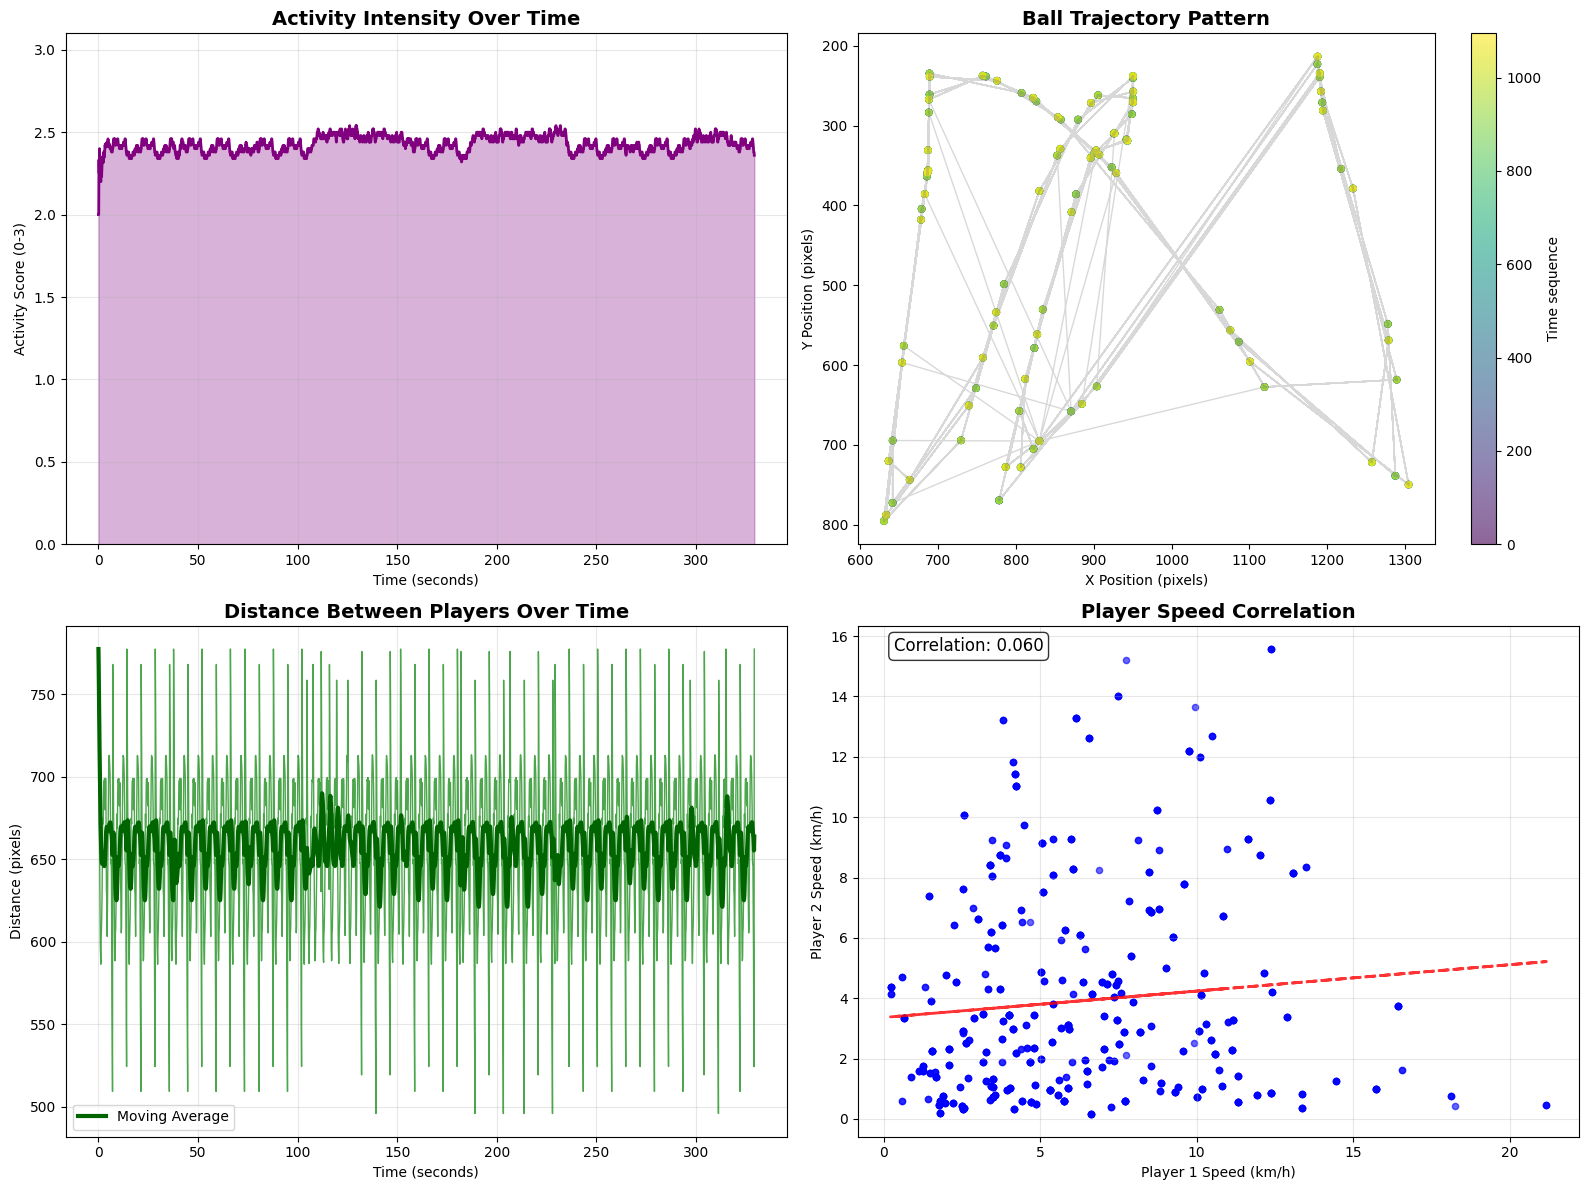

✅ Temporal pattern visualizations created


In [34]:
# Create temporal pattern visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Activity intensity over time
ax1.set_title('Activity Intensity Over Time', fontsize=14, fontweight='bold')

# Sample data for visualization
sample_interval = max(1, len(df) // 2000)
sample_df = df.iloc[::sample_interval].copy()

# Recreate activity score for sample
activity_score = pd.Series(0, index=sample_df.index)
if 'ball_detected' in sample_df.columns:
    activity_score += sample_df['ball_detected'].astype(int)
for player_id in [1, 2]:
    detected_col = f'player_{player_id}_detected'
    if detected_col in sample_df.columns:
        activity_score += sample_df[detected_col].astype(int)

if activity_score.sum() > 0:
    # Smooth the activity score
    window_size = min(50, len(sample_df) // 10)
    activity_smooth = activity_score.rolling(window=window_size, min_periods=1).mean()
    
    ax1.plot(sample_df['time_seconds'], activity_smooth, linewidth=2, color='purple')
    ax1.fill_between(sample_df['time_seconds'], activity_smooth, alpha=0.3, color='purple')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Activity Score (0-3)')
    ax1.set_ylim(0, 3.1)
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No activity data available', transform=ax1.transAxes, ha='center', va='center')

# 2. Ball trajectory visualization
ax2.set_title('Ball Trajectory Pattern', fontsize=14, fontweight='bold')

if 'ball_center_x' in df.columns and 'ball_center_y' in df.columns:
    ball_data = df[['ball_center_x', 'ball_center_y']].dropna()
    
    if len(ball_data) > 0:
        # Sample ball data for visualization
        ball_sample = ball_data.iloc[::max(1, len(ball_data)//1000)]
        
        # Create trajectory plot with color gradient
        scatter = ax2.scatter(ball_sample['ball_center_x'], ball_sample['ball_center_y'],
                            c=range(len(ball_sample)), cmap='viridis', alpha=0.6, s=20)
        
        # Add trajectory lines
        ax2.plot(ball_sample['ball_center_x'], ball_sample['ball_center_y'], 
                alpha=0.3, linewidth=1, color='gray')
        
        ax2.set_xlabel('X Position (pixels)')
        ax2.set_ylabel('Y Position (pixels)')
        ax2.invert_yaxis()  # Invert Y to match video coordinate system
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Time sequence')
else:
    ax2.text(0.5, 0.5, 'No ball trajectory data available', transform=ax2.transAxes, ha='center', va='center')

# 3. Player distance over time
ax3.set_title('Distance Between Players Over Time', fontsize=14, fontweight='bold')

if all(f'player_{i}_center_x' in sample_df.columns for i in [1, 2]):
    player_data = sample_df[['player_1_center_x', 'player_1_center_y', 
                           'player_2_center_x', 'player_2_center_y', 'time_seconds']].dropna()
    
    if len(player_data) > 0:
        # Calculate distance between players
        distances = np.sqrt(
            (player_data['player_1_center_x'] - player_data['player_2_center_x'])**2 +
            (player_data['player_1_center_y'] - player_data['player_2_center_y'])**2
        )
        
        ax3.plot(player_data['time_seconds'], distances, linewidth=1, alpha=0.7, color='green')
        
        # Add moving average
        if len(distances) > 10:
            window_size = min(20, len(distances) // 5)
            distances_smooth = distances.rolling(window=window_size, min_periods=1).mean()
            ax3.plot(player_data['time_seconds'], distances_smooth, linewidth=3, color='darkgreen', label='Moving Average')
            ax3.legend()
        
        ax3.set_xlabel('Time (seconds)')
        ax3.set_ylabel('Distance (pixels)')
        ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No player distance data available', transform=ax3.transAxes, ha='center', va='center')

# 4. Speed correlation analysis
ax4.set_title('Player Speed Correlation', fontsize=14, fontweight='bold')

if all(f'player_{i}_speed_kmh' in df.columns for i in [1, 2]):
    speed_data = df[['player_1_speed_kmh', 'player_2_speed_kmh']].dropna()
    
    # Filter realistic speeds
    speed_data = speed_data[(speed_data['player_1_speed_kmh'] <= 50) & 
                           (speed_data['player_2_speed_kmh'] <= 50)]
    
    if len(speed_data) > 0:
        # Sample for visualization
        speed_sample = speed_data.sample(n=min(1000, len(speed_data)))
        
        ax4.scatter(speed_sample['player_1_speed_kmh'], speed_sample['player_2_speed_kmh'], 
                   alpha=0.6, s=20, color='blue')
        
        # Add correlation line
        correlation = speed_data['player_1_speed_kmh'].corr(speed_data['player_2_speed_kmh'])
        
        # Fit a line
        z = np.polyfit(speed_sample['player_1_speed_kmh'], speed_sample['player_2_speed_kmh'], 1)
        p = np.poly1d(z)
        ax4.plot(speed_sample['player_1_speed_kmh'], p(speed_sample['player_1_speed_kmh']), 
                "r--", alpha=0.8, linewidth=2)
        
        ax4.set_xlabel('Player 1 Speed (km/h)')
        ax4.set_ylabel('Player 2 Speed (km/h)')
        ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=ax4.transAxes, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No speed correlation data available', transform=ax4.transAxes, ha='center', va='center')

plt.tight_layout()
plt.show()

print("✅ Temporal pattern visualizations created")

## 5. Performance Metrics and Summary

In [35]:
# Performance metrics and summary
print("🏆 PERFORMANCE METRICS AND SUMMARY")
print("=" * 60)

# Create comprehensive summary
summary_stats = {
    'Dataset Information': {
        'Total frames': f"{len(df):,}",
        'Duration': f"{df['time_seconds'].max():.1f} seconds ({df['time_seconds'].max()/60:.1f} minutes)",
        'Frame rate': "30 fps",
        'Columns': len(df.columns)
    }
}

# Detection performance
detection_stats = {}
if 'ball_detected' in df.columns:
    detection_stats['Ball detection rate'] = f"{df['ball_detected'].mean():.1%}"
    detection_stats['Ball frames'] = f"{df['ball_detected'].sum():,}"

for player_id in [1, 2]:
    detected_col = f'player_{player_id}_detected'
    if detected_col in df.columns:
        detection_stats[f'Player {player_id} detection rate'] = f"{df[detected_col].mean():.1%}"
        detection_stats[f'Player {player_id} frames'] = f"{df[detected_col].sum():,}"

if 'all_objects_detected' in df.columns:
    detection_stats['All objects detected'] = f"{df['all_objects_detected'].mean():.1%}"

summary_stats['Detection Performance'] = detection_stats

# Movement statistics
movement_stats = {}

for player_id in [1, 2]:
    speed_col = f'player_{player_id}_speed_kmh'
    distance_col = f'player_{player_id}_distance_meters'
    
    if speed_col in df.columns:
        speeds = df[speed_col].dropna()
        realistic_speeds = speeds[speeds <= 50]
        
        if len(realistic_speeds) > 0:
            movement_stats[f'Player {player_id} avg speed'] = f"{realistic_speeds.mean():.1f} km/h"
            movement_stats[f'Player {player_id} max speed'] = f"{realistic_speeds.max():.1f} km/h"
    
    if distance_col in df.columns:
        distances = df[distance_col].dropna()
        if len(distances) > 0:
            movement_stats[f'Player {player_id} total distance'] = f"{distances.sum():.1f} m"

if 'ball_speed_kmh' in df.columns:
    ball_speeds = df['ball_speed_kmh'].dropna()
    realistic_ball_speeds = ball_speeds[ball_speeds <= 200]
    
    if len(realistic_ball_speeds) > 0:
        movement_stats['Ball avg speed'] = f"{realistic_ball_speeds.mean():.1f} km/h"
        movement_stats['Ball max speed'] = f"{realistic_ball_speeds.max():.1f} km/h"

if 'ball_distance_meters' in df.columns:
    ball_distances = df['ball_distance_meters'].dropna()
    if len(ball_distances) > 0:
        movement_stats['Ball total distance'] = f"{ball_distances.sum():.1f} m"

summary_stats['Movement Statistics'] = movement_stats

# Court usage statistics
court_stats = {}

for player_id in [1, 2]:
    region_col = f'player_{player_id}_court_region'
    if region_col in df.columns:
        regions = df[region_col].value_counts()
        if len(regions) > 0:
            most_common_region = regions.index[0]
            percentage = (regions.iloc[0] / len(df)) * 100
            court_stats[f'Player {player_id} most common region'] = f"{most_common_region.replace('_', ' ').title()} ({percentage:.1f}%)"

if court_stats:
    summary_stats['Court Usage'] = court_stats

# Data quality metrics
quality_stats = {
    'Missing data percentage': f"{(df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.1f}%",
    'Complete frames (all objects)': f"{df['all_objects_detected'].sum():,}" if 'all_objects_detected' in df.columns else "N/A"
}

# Calculate data completeness for key columns
key_columns = [col for col in df.columns if any(x in col for x in ['center_x', 'center_y', 'detected'])]
if key_columns:
    completeness = ((len(df) * len(key_columns)) - df[key_columns].isnull().sum().sum()) / (len(df) * len(key_columns))
    quality_stats['Key data completeness'] = f"{completeness:.1%}"

summary_stats['Data Quality'] = quality_stats

# Print formatted summary
for category, stats in summary_stats.items():
    print(f"\n📊 {category}:")
    for metric, value in stats.items():
        print(f"   {metric}: {value}")

# ML4QS Chapter 2 Insights
print(f"\n🎓 ML4QS CHAPTER 2 INSIGHTS")
print("=" * 50)

insights = [
    "✅ Temporal Data Structure: Successfully created time-series dataset from video frames",
    "✅ Multi-Object Tracking: Coordinated tracking of ball and multiple players",
    "✅ Data Quality Assessment: Systematic analysis of missing data patterns",
    "✅ Feature Engineering: Derived speed, distance, and region metrics from raw positions",
    "✅ Real-World Calibration: Court measurements enable meaningful physical units",
    "✅ Statistical Analysis: Movement patterns and performance metrics extracted"
]

for insight in insights:
    print(f"  {insight}")

print(f"\n💡 Key Findings:")

# Automatic insights based on data
findings = []

if 'ball_detected' in df.columns:
    ball_rate = df['ball_detected'].mean()
    if ball_rate > 0.5:
        findings.append(f"High ball detection rate ({ball_rate:.1%}) indicates good tracking quality")
    else:
        findings.append(f"Moderate ball detection rate ({ball_rate:.1%}) suggests challenging tracking conditions")

if 'all_objects_detected' in df.columns:
    complete_rate = df['all_objects_detected'].mean()
    if complete_rate > 0.3:
        findings.append(f"Good multi-object tracking with {complete_rate:.1%} complete frames")
    else:
        findings.append(f"Partial object tracking with {complete_rate:.1%} complete frames")

# Player comparison
player_speeds = []
for player_id in [1, 2]:
    speed_col = f'player_{player_id}_speed_kmh'
    if speed_col in df.columns:
        speeds = df[speed_col].dropna()
        realistic_speeds = speeds[speeds <= 50]
        if len(realistic_speeds) > 0:
            player_speeds.append((player_id, realistic_speeds.mean()))

if len(player_speeds) == 2:
    if abs(player_speeds[0][1] - player_speeds[1][1]) > 2:
        faster_player = player_speeds[0][0] if player_speeds[0][1] > player_speeds[1][1] else player_speeds[1][0]
        findings.append(f"Player {faster_player} shows higher average movement speed")
    else:
        findings.append("Players show similar movement speeds")

for i, finding in enumerate(findings, 1):
    print(f"  {i}. {finding}")

print(f"\n✅ ANALYSIS COMPLETE!")
print(f"📈 This dataset demonstrates successful application of ML4QS Chapter 2 concepts")
print(f"🎾 Ready for advanced tennis analytics and machine learning applications")
print("=" * 60)

🏆 PERFORMANCE METRICS AND SUMMARY

📊 Dataset Information:
   Total frames: 9,882
   Duration: 329.4 seconds (5.5 minutes)
   Frame rate: 30 fps
   Columns: 72

📊 Detection Performance:
   Ball detection rate: 44.3%
   Ball frames: 4,382
   Player 1 detection rate: 100.0%
   Player 1 frames: 9,882
   Player 2 detection rate: 100.0%
   Player 2 frames: 9,882
   All objects detected: 44.3%

📊 Movement Statistics:
   Player 1 avg speed: 6.3 km/h
   Player 1 max speed: 39.8 km/h
   Player 1 total distance: 804.6 m
   Player 2 avg speed: 3.9 km/h
   Player 2 max speed: 38.8 km/h
   Player 2 total distance: 391.8 m
   Ball avg speed: 4.1 km/h
   Ball max speed: 44.5 km/h
   Ball total distance: 378.2 m

📊 Court Usage:
   Player 1 most common region: Back Court Near (100.0%)
   Player 2 most common region: Back Court Far (51.5%)

📊 Data Quality:
   Missing data percentage: 8.2%
   Complete frames (all objects): 4,382
   Key data completeness: 89.9%

🎓 ML4QS CHAPTER 2 INSIGHTS
  ✅ Temporal Data

In [36]:
# Export analysis results
print("💾 EXPORTING ANALYSIS RESULTS")
print("=" * 40)

# Create analysis timestamp
analysis_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

try:
    # Export summary statistics as JSON
    import json
    
    analysis_results = {
        'analysis_timestamp': analysis_timestamp,
        'dataset_file': dataset_file,
        'summary_statistics': summary_stats,
        'ml4qs_insights': insights,
        'key_findings': findings
    }
    
    results_filename = f'tennis_analysis_results_{analysis_timestamp}.json'
    with open(results_filename, 'w') as f:
        json.dump(analysis_results, f, indent=2)
    
    print(f"✅ Analysis results exported: {results_filename}")
    
    # Export processed data sample for further analysis
    if len(df) > 10000:
        sample_size = 10000
        sample_df = df.sample(n=sample_size, random_state=42)
        sample_filename = f'tennis_dataset_sample_{analysis_timestamp}.csv'
        sample_df.to_csv(sample_filename)
        print(f"✅ Dataset sample exported: {sample_filename} ({sample_size:,} rows)")
    
    # Create analysis summary text report
    report_filename = f'tennis_analysis_report_{analysis_timestamp}.txt'
    with open(report_filename, 'w') as f:
        f.write("TENNIS DATASET ANALYSIS REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Dataset File: {dataset_file}\n\n")
        
        for category, stats in summary_stats.items():
            f.write(f"{category}:\n")
            for metric, value in stats.items():
                f.write(f"  {metric}: {value}\n")
            f.write("\n")
        
        f.write("ML4QS INSIGHTS:\n")
        for insight in insights:
            f.write(f"  {insight}\n")
        
        f.write("\nKEY FINDINGS:\n")
        for i, finding in enumerate(findings, 1):
            f.write(f"  {i}. {finding}\n")
    
    print(f"✅ Analysis report exported: {report_filename}")
    
    print(f"\n📋 Export Summary:")
    print(f"   • JSON results: {results_filename}")
    print(f"   • Text report: {report_filename}")
    if len(df) > 10000:
        print(f"   • Data sample: {sample_filename}")
    
except Exception as e:
    print(f"❌ Error exporting results: {e}")

print(f"\n🎯 TENNIS DATASET ANALYSIS COMPLETE!")
print(f"📊 Dataset successfully analyzed using ML4QS Chapter 2 methodologies")
print(f"🏆 Results demonstrate comprehensive temporal data analysis capabilities")

💾 EXPORTING ANALYSIS RESULTS
✅ Analysis results exported: tennis_analysis_results_20250622_015116.json
✅ Analysis report exported: tennis_analysis_report_20250622_015116.txt

📋 Export Summary:
   • JSON results: tennis_analysis_results_20250622_015116.json
   • Text report: tennis_analysis_report_20250622_015116.txt

🎯 TENNIS DATASET ANALYSIS COMPLETE!
📊 Dataset successfully analyzed using ML4QS Chapter 2 methodologies
🏆 Results demonstrate comprehensive temporal data analysis capabilities
